<a href="https://colab.research.google.com/github/chuqasmi/GEN-AI-/blob/main/Node_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

import torch_geometric
print(torch_geometric.__version__)

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.8 MB/s eta 0:00:00
2.5.0


# Node Classification with Graph Neural Networks

This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data.y)
uni, count = torch.unique(data.y, return_counts=True)
print(uni, count)

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
tensor([3, 4, 4,  ..., 3, 3, 3])
tensor([0, 1, 2, 3, 4, 5, 6]) tensor([351, 217, 418, 818, 426, 298, 180])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.
For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

This graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing.

We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).

## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss, val_loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss, val_loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Validation loss: {val_loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9615, Validation loss: 2.0364
Epoch: 002, Loss: 1.9538, Validation loss: 2.0268
Epoch: 003, Loss: 1.9452, Validation loss: 2.0164
Epoch: 004, Loss: 1.9357, Validation loss: 2.0056
Epoch: 005, Loss: 1.9250, Validation loss: 1.9948
Epoch: 006, Loss: 1.9136, Validation loss: 1.9837
Epoch: 007, Loss: 1.9011, Validation loss: 1.9725
Epoch: 008, Loss: 1.8877, Validation loss: 1.9612
Epoch: 009, Loss: 1.8735, Validation loss: 1.9498
Epoch: 010, Loss: 1.8583, Validation loss: 1.9387
Epoch: 011, Loss: 1.8421, Validation loss: 1.9278
Epoch: 012, Loss: 1.8250, Validation loss: 1.9171
Epoch: 013, Loss: 1.8068, Validation loss: 1.9068
Epoch: 014, Loss: 1.7875, Validation loss: 1.8970
Epoch: 015, Loss: 1.7672, Validation loss: 1.8875
Epoch: 016, Loss: 1.7457, Validation loss: 1.8783
Epoch: 017, Loss: 1.7232, Validation loss: 1.8694
Epoch: 018, Loss: 1.6996, Validation loss: 1.8609
Epoch: 019, Loss: 1.6749, Validation loss: 1.8526
Epoch: 020, Loss: 1.6492, Validation loss: 1.8445


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5930


As one can see, our MLP performs rather bad with only about 59% test accuracy.
But why does the MLP do not perform better?
The main reason for that is that this model suffers from heavy overfitting due to only having access to a **small amount of training nodes**, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: **Cited papers are very likely related to the category of a document**.
That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.



## Training a Graph Neural Network (GNN)

### Training with GCN(Graph Convolutional Network)
We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

We replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.

In [ ]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss, val_loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 100):
    loss, val_loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Validation loss: {val_loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9464, Validation loss: 1.9468
Epoch: 002, Loss: 1.9400, Validation loss: 1.9419
Epoch: 003, Loss: 1.9330, Validation loss: 1.9409
Epoch: 004, Loss: 1.9239, Validation loss: 1.9368
Epoch: 005, Loss: 1.9139, Validation loss: 1.9328
Epoch: 006, Loss: 1.9038, Validation loss: 1.9283
Epoch: 007, Loss: 1.8928, Validation loss: 1.9234
Epoch: 008, Loss: 1.8810, Validation loss: 1.9179
Epoch: 009, Loss: 1.8686, Validation loss: 1.9118
Epoch: 010, Loss: 1.8557, Validation loss: 1.9051
Epoch: 011, Loss: 1.8422, Validation loss: 1.8980
Epoch: 012, Loss: 1.8281, Validation loss: 1.8907
Epoch: 013, Loss: 1.8135, Validation loss: 1.8833
Epoch: 014, Loss: 1.7983, Validation loss: 1.8761
Epoch: 015, Loss: 1.7826, Validation loss: 1.8689
Epoch: 016, Loss: 1.7663, Validation loss: 1.8613
Epoch: 017, Loss: 1.7495, Validation loss: 1.8534
Epoch: 018, Loss: 1.7322, Validation loss: 1.8452
Epoch: 019, Loss: 1.7144, Validation loss: 1.8368
Epoch: 020, Loss: 1.6959, Validation loss: 1.8281


After training the model, we can check its test accuracy:

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8090


**There it is!**
By simply swapping the linear layers with GNN layers, we can reach over **80% of test accuracy**!
This is in stark contrast to the 59% of test accuracy obtained by our MLP, indicating that relational information plays a crucial role in obtaining better performance.


### Training with GAT(Graph Attention Network)

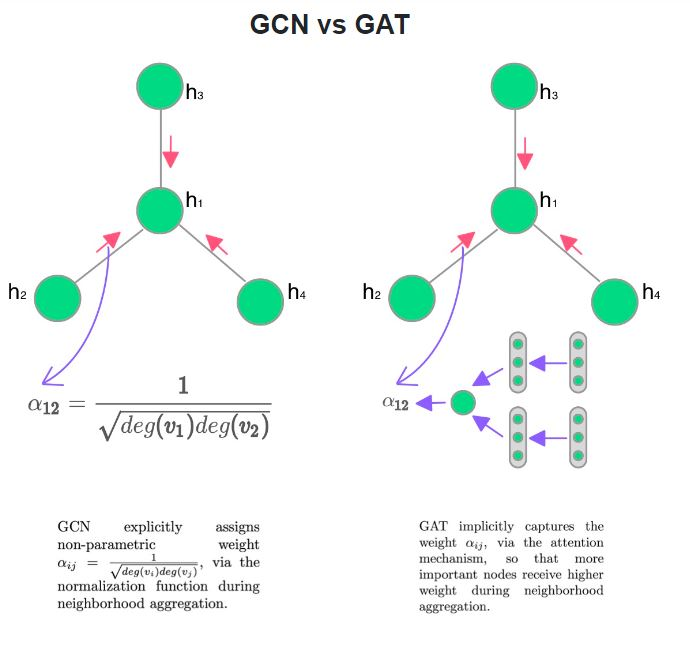



In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=8, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * 8, dataset.num_classes, heads=1, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8)
print(model)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)


In [ ]:
model = GAT(hidden_channels=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(1, 100):
    loss, val_loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Validation loss: {val_loss:.4f}')

Epoch: 001, Loss: 1.9453, Validation loss: 1.9455
Epoch: 002, Loss: 1.9344, Validation loss: 1.9424
Epoch: 003, Loss: 1.9202, Validation loss: 1.9341
Epoch: 004, Loss: 1.8993, Validation loss: 1.9233
Epoch: 005, Loss: 1.8816, Validation loss: 1.9146
Epoch: 006, Loss: 1.8625, Validation loss: 1.8991
Epoch: 007, Loss: 1.8378, Validation loss: 1.8849
Epoch: 008, Loss: 1.8301, Validation loss: 1.8678
Epoch: 009, Loss: 1.7998, Validation loss: 1.8549
Epoch: 010, Loss: 1.7478, Validation loss: 1.8302
Epoch: 011, Loss: 1.7523, Validation loss: 1.8226
Epoch: 012, Loss: 1.7314, Validation loss: 1.8054
Epoch: 013, Loss: 1.6932, Validation loss: 1.7908
Epoch: 014, Loss: 1.6408, Validation loss: 1.7756
Epoch: 015, Loss: 1.6218, Validation loss: 1.7625
Epoch: 016, Loss: 1.5755, Validation loss: 1.7260
Epoch: 017, Loss: 1.5395, Validation loss: 1.7156
Epoch: 018, Loss: 1.5233, Validation loss: 1.6952
Epoch: 019, Loss: 1.4910, Validation loss: 1.6802
Epoch: 020, Loss: 1.4786, Validation loss: 1.6511


In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8240


## Conclusion

In this chapter, you have seen how to apply GNNs to real-world problems, and, in particular, how they can effectively be used for boosting a model's performance.